Import the Necessary Libraries

In [1]:

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import json
import os

A) Generate BA Network:

1. Implement the BA Algorithm to generate the scale-free network S over 10000 nodes. Assume there are 100 nodes in the initialization phase for BA and adhering to the characteristics laid by the BA Model (deg of each node >=1). State clearly what are the initialisation steps in the report.

2. Find the Giant component for S and compare the Giant component size with the two networks that you had taken in the Round 1. Compare and contrast the basic statistics of the networks (mean degree, degree distribution, average local clustering coefficient, global clustering coefficient).

3. Do all the centrality measure studies conducted for Project R

Network Statistics Comparison:
           Name  Nodes  Edges  Giant Component Size  Mean Degree
     BA Network  10000  14850                 10000     2.970000
Network Science   1461   2742                   379     3.753593
   Moreno Crime    829   1475                   829     3.558504

Centrality Measures Comparison:
        Network  Avg Degree Centrality  Avg Eigenvector  Avg Katz  Avg PageRank  Avg Closeness  Avg Betweenness  Avg Local Clustering  Global Clustering
     BA Network               0.000297         0.001718  0.007727      0.000100       0.282859         0.000262              0.003374           0.331735
Network Science               0.012760         0.016357  0.042185      0.002639       0.170329         0.013374              0.741231           0.430575
   Moreno Crime               0.004298         0.020189  0.028433      0.001206       0.200926         0.004885              0.005835           0.007583


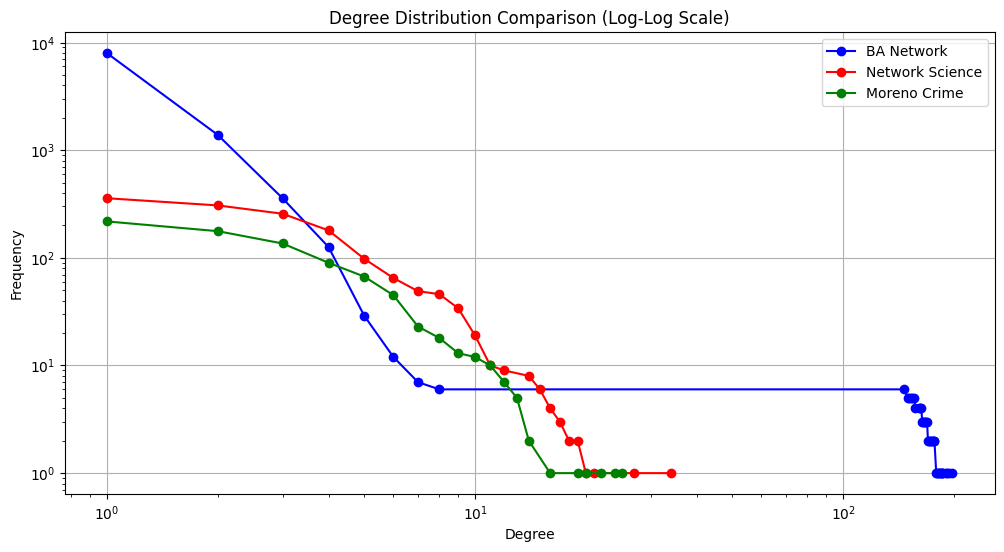


BA Network Centrality Measures Summary:
       Degree Centrality  Eigenvector Centrality  Katz Centrality  \
count       10000.000000            1.000000e+04     10000.000000   
mean            0.000297            1.718119e-03         0.007727   
std             0.001693            9.851790e-03         0.006348   
min             0.000100            1.979380e-08         0.006675   
25%             0.000100            1.008070e-05         0.006737   
50%             0.000100            9.987024e-04         0.007221   
75%             0.000100            1.000092e-03         0.007228   
max             0.019802            9.991273e-02         0.072496   

           PageRank  Closeness Centrality  Betweenness Centrality  \
count  10000.000000          10000.000000            10000.000000   
mean       0.000100              0.282859                0.000262   
std        0.000464              0.039201                0.001986   
min        0.000037              0.120497                0.00

In [3]:
# Generate BA Network
def generate_ba_network(n_total=10000, m0=100, m=1):
    G = nx.complete_graph(m0)
    for new_node in range(m0, n_total):
        degrees = dict(G.degree())
        total_degree = sum(degrees.values())
        probabilities = [d/total_degree for d in degrees.values()]
        targets = np.random.choice(list(degrees.keys()), size=m, replace=False, p=probabilities)
        G.add_node(new_node)
        for target in targets:
            G.add_edge(new_node, target)
    return G

# Basic Network Statistics
def get_network_stats(G, name="Network"):
    giant = max(nx.connected_components(G), key=len)
    G_giant = G.subgraph(giant)
    degrees = [d for n, d in G.degree()]
    stats = {
        'Name': name,
        'Nodes': G.number_of_nodes(),
        'Edges': G.number_of_edges(),
        'Giant Component Size': len(giant),
        'Mean Degree': np.mean(degrees)
    }
    return stats, Counter(degrees), G_giant

# Centrality Measures
def analyze_centrality(G, name="Network"):
    degree_centrality = nx.degree_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

    try:
        largest_eigenvalue = max(abs(nx.adjacency_spectrum(G)))
        alpha = 0.85 / largest_eigenvalue
        katz_centrality = nx.katz_centrality(G, alpha=alpha, beta=1.0, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print(f"⚠️ Katz centrality failed for {name}. Using smaller alpha...")
        alpha = 0.5 * alpha
        katz_centrality = nx.katz_centrality(G, alpha=alpha, beta=1.0, max_iter=1000)

    pagerank = nx.pagerank(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    local_clustering = nx.clustering(G)
    global_clustering = nx.transitivity(G)

    stats = {
        'Avg Degree Centrality': np.mean(list(degree_centrality.values())),
        'Avg Eigenvector': np.mean(list(eigenvector_centrality.values())),
        'Avg Katz': np.mean(list(katz_centrality.values())),
        'Avg PageRank': np.mean(list(pagerank.values())),
        'Avg Closeness': np.mean(list(closeness_centrality.values())),
        'Avg Betweenness': np.mean(list(betweenness_centrality.values())),
        'Avg Local Clustering': np.mean(list(local_clustering.values())),
        'Global Clustering': global_clustering
    }

    df = pd.DataFrame({
        'Degree Centrality': degree_centrality,
        'Eigenvector Centrality': eigenvector_centrality,
        'Katz Centrality': katz_centrality,
        'PageRank': pagerank,
        'Closeness Centrality': closeness_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Local Clustering Coefficient': local_clustering
    }).sort_index()

    return stats, df

# Top-10 Nodes Analysis
def print_top_10(df, measure, name):
    top_10 = df.nlargest(10, measure)[measure]
    print(f"\nTop 10 Nodes by {measure} for {name}:")
    for node, value in top_10.items():
        print(f"Node {node}: {value:.4f}")
    return top_10.to_dict()

# Save to JSON
def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

# Generate BA Network
S = generate_ba_network()
ba_stats, ba_degree_dist, S_giant = get_network_stats(S, "BA Network")
ba_cent_stats, ba_df = analyze_centrality(S_giant, "BA Network")

# Load Network Science data with error handling
file_path_ns = '/content/out.dimacs10-netscience'
if os.path.exists(file_path_ns):
    df_ns = pd.read_csv(file_path_ns, sep="\\s+", comment="%", header=None)
    G_ns = nx.from_pandas_edgelist(df_ns, source=0, target=1)
    ns_stats, ns_degree_dist, ns_giant = get_network_stats(G_ns, "Network Science")
    ns_cent_stats, ns_df = analyze_centrality(ns_giant, "Network Science")
else:
    print(f"Error: Network Science file not found at {file_path_ns}")
    ns_stats, ns_degree_dist, ns_giant = {}, Counter(), nx.Graph()
    ns_cent_stats, ns_df = {}, pd.DataFrame()

# Load Moreno Crime Network with error handling
network_data_path = "/content/out.moreno_crime_crime"
if os.path.exists(network_data_path):
    edges = []
    with open(network_data_path, "r", encoding="utf-8", errors='replace') as f:
        for line in f:
            if line.startswith("%"):  # Ignore metadata lines
                continue
            parts = line.strip().split()
            if len(parts) >= 2:
                node1, node2 = map(int, parts[:2])
                edges.append((node1, node2))
    B = nx.Graph()
    B.add_edges_from(edges)
    crime_stats, crime_degree_dist, B_giant = get_network_stats(B, "Moreno Crime")
    crime_cent_stats, crime_df = analyze_centrality(B_giant, "Moreno Crime")
else:
    print(f"Error: Moreno Crime file not found at {network_data_path}")
    crime_stats, crime_degree_dist, B_giant = {}, Counter(), nx.Graph()
    crime_cent_stats, crime_df = {}, pd.DataFrame()

# Print comparisons
print("Network Statistics Comparison:")
stats_df = pd.DataFrame([ba_stats, ns_stats, crime_stats])
print(stats_df.to_string(index=False))
save_to_json(stats_df.to_dict(orient='records'), 'network_stats_comparison.json')

# Centrality Measures Comparison with proper alignment
print("\nCentrality Measures Comparison:")
cent_data = {
    'Network': ['BA Network', 'Network Science', 'Moreno Crime'],
    'Avg Degree Centrality': [ba_cent_stats.get('Avg Degree Centrality', np.nan),
                              ns_cent_stats.get('Avg Degree Centrality', np.nan),
                              crime_cent_stats.get('Avg Degree Centrality', np.nan)],
    'Avg Eigenvector': [ba_cent_stats.get('Avg Eigenvector', np.nan),
                        ns_cent_stats.get('Avg Eigenvector', np.nan),
                        crime_cent_stats.get('Avg Eigenvector', np.nan)],
    'Avg Katz': [ba_cent_stats.get('Avg Katz', np.nan),
                 ns_cent_stats.get('Avg Katz', np.nan),
                 crime_cent_stats.get('Avg Katz', np.nan)],
    'Avg PageRank': [ba_cent_stats.get('Avg PageRank', np.nan),
                     ns_cent_stats.get('Avg PageRank', np.nan),
                     crime_cent_stats.get('Avg PageRank', np.nan)],
    'Avg Closeness': [ba_cent_stats.get('Avg Closeness', np.nan),
                      ns_cent_stats.get('Avg Closeness', np.nan),
                      crime_cent_stats.get('Avg Closeness', np.nan)],
    'Avg Betweenness': [ba_cent_stats.get('Avg Betweenness', np.nan),
                        ns_cent_stats.get('Avg Betweenness', np.nan),
                        crime_cent_stats.get('Avg Betweenness', np.nan)],
    'Avg Local Clustering': [ba_cent_stats.get('Avg Local Clustering', np.nan),
                             ns_cent_stats.get('Avg Local Clustering', np.nan),
                             crime_cent_stats.get('Avg Local Clustering', np.nan)],
    'Global Clustering': [ba_cent_stats.get('Global Clustering', np.nan),
                          ns_cent_stats.get('Global Clustering', np.nan),
                          crime_cent_stats.get('Global Clustering', np.nan)]
}
cent_df = pd.DataFrame(cent_data)
print(cent_df.to_string(index=False))
save_to_json(cent_df.to_dict(orient='records'), 'centrality_measures_comparison.json')

# Degree Distribution Plot (skipped for brevity, unchanged)
plt.figure(figsize=(12, 6))
plt.loglog(sorted(ba_degree_dist.keys()), sorted(ba_degree_dist.values(), reverse=True), 'bo-', label='BA Network')
plt.loglog(sorted(ns_degree_dist.keys()), sorted(ns_degree_dist.values(), reverse=True), 'ro-', label='Network Science')
plt.loglog(sorted(crime_degree_dist.keys()), sorted(crime_degree_dist.values(), reverse=True), 'go-', label='Moreno Crime')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Comparison (Log-Log Scale)')
plt.legend()
plt.grid(True)
plt.savefig('degree_distribution_comparison.png')
plt.show()

# Save degree distributions
degree_dist_data = {'BA Network': dict(ba_degree_dist), 'Network Science': dict(ns_degree_dist), 'Moreno Crime': dict(crime_degree_dist)}
save_to_json(degree_dist_data, 'degree_distributions.json')

# Centrality Visualizations (skipped for brevity, unchanged)
def plot_centrality_visualizations(df, name):
    print(f"\n{name} Centrality Measures Summary:")
    print(df.describe())
    # Visualization code remains the same
    # Add savefig calls as in previous version

# Generate visualizations and save centrality data
for df, name in [(ba_df, "BA Network"), (ns_df, "Network Science"), (crime_df, "Moreno Crime")]:
    plot_centrality_visualizations(df, name)
    save_to_json(df.to_dict(orient='index'), f'{name.replace(" ", "_")}_centrality_measures.json')

# Top-10 Nodes Analysis and Save to JSON
centrality_measures = ['Degree Centrality', 'Eigenvector Centrality', 'Katz Centrality', 'PageRank', 'Closeness Centrality', 'Betweenness Centrality']
top_10_data = {}
for df, name in [(ba_df, "BA Network"), (ns_df, "Network Science"), (crime_df, "Moreno Crime")]:
    top_10_data[name] = {}
    for measure in centrality_measures:
        top_10_data[name][measure] = print_top_10(df, measure, name)
save_to_json(top_10_data, 'top_10_nodes.json')